In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
slim = tf.contrib.slim


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# 字元集
CHAR_SET = [str(i) for i in range(10)]
CHAR_SET_LEN = len(CHAR_SET)
# 批次大小
BATCH_SIZE = 10
# tfrecord文件
TFRECORD_FILE = 'captcha/train.tfrecord'

In [3]:
def read_and_decode(serial_exmp):
    features = tf.parse_single_example(serial_exmp,
                                       features={
                                           'image': tf.FixedLenFeature([], tf.string),
                                           'label0': tf.FixedLenFeature([], tf.int64),
                                           'label1': tf.FixedLenFeature([], tf.int64),
                                           'label2': tf.FixedLenFeature([], tf.int64),
                                           'label3': tf.FixedLenFeature([], tf.int64)
                                       })
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image,[224, 224])
    image = tf.cast(image, tf.float32) / 255.0    # 0 to 1
    image = tf.subtract(image, 0.5)               # -0.5 to 0.5
    image = tf.multiply(image, 2.0)               # -1 to 1

    label0 = tf.cast(features['label0'], tf.int32)
    label1 = tf.cast(features['label1'], tf.int32)
    label2 = tf.cast(features['label2'], tf.int32)
    label3 = tf.cast(features['label3'], tf.int32)
    return image, label0, label1, label2, label3

dataset = tf.data.TFRecordDataset(TFRECORD_FILE)

# 此時dataset中的一個元素是(image, label0, label1, label2, label3)
dataset = dataset.map(read_and_decode)
dataset = dataset.shuffle(buffer_size=2000).batch(BATCH_SIZE).repeat()

In [4]:
def alexnet_v2_captcha_multi(inputs,
                             num_classes=10,
                             is_training=True,
                             dropout_keep_prob=0.5,
                             spatial_squeeze=True,
                             scope_name='alexnet_v2_captcha_multi',
                             global_pool=False):
    '''
    參考 tensorflow github source code，改成 multi task learning
    '''
    with tf.variable_scope(scope_name) as sc:
        net = slim.conv2d(inputs, 64, [11, 11], 4, padding='VALID', scope='conv1')
        net = slim.max_pool2d(net, [3, 3], 2, scope='pool1')   
        net = slim.conv2d(net, 192, [5, 5], scope='conv2')
        net = slim.max_pool2d(net, [3, 3], 2, scope='pool2')
        net = slim.conv2d(net, 384, [3, 3], scope='conv3')
        net = slim.conv2d(net, 384, [3, 3], scope='conv4')
        net = slim.conv2d(net, 256, [3, 3], scope='conv5')
        net = slim.max_pool2d(net, [3, 3], 2, scope='pool5')

        with slim.arg_scope([slim.conv2d],
                            weights_initializer=tf.truncated_normal_initializer(0.0, 0.005),
                            weights_regularizer=slim.l2_regularizer(0.0005),
                            biases_initializer=tf.constant_initializer(0.1)):
            net = slim.conv2d(net, 4096, [5, 5], padding='VALID', scope='fc6')
            net = slim.dropout(net, dropout_keep_prob, is_training=is_training, scope='dropout6')
            net = slim.conv2d(net, 4096, [1, 1], scope='fc7')
            net = slim.dropout(net, dropout_keep_prob, is_training=is_training, scope='dropout7')

            if num_classes:
                
                net0 = slim.conv2d(net, num_classes, [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   biases_initializer=tf.zeros_initializer(),
                                   scope='fc8_0')

                net1 = slim.conv2d(net, num_classes, [1,1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   biases_initializer=tf.zeros_initializer(),
                                   scope='fc8_1')

                net2 = slim.conv2d(net, num_classes, [1,1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   biases_initializer=tf.zeros_initializer(),
                                   scope='fc8_2')

                net3 = slim.conv2d(net, num_classes, [1,1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   biases_initializer=tf.zeros_initializer(),
                                   scope='fc8_3')

            # 壓縮維度 4D to 2D，[batch, 1, 1, 10] to [batch, 10]
            if spatial_squeeze:
                net0 = tf.squeeze(net0, [1, 2], name='fc8_0/squeezed')
                net1 = tf.squeeze(net1, [1, 2], name='fc8_1/squeezed')
                net2 = tf.squeeze(net2, [1, 2], name='fc8_2/squeezed')
                net3 = tf.squeeze(net3, [1, 2], name='fc8_3/squeezed')
    return net0, net1, net2, net3

In [5]:
# 定義網路變數
x = tf.placeholder(tf.float32, [None, 224, 224])

X = tf.reshape(x, [BATCH_SIZE, 224, 224, 1])
logits0, logits1, logits2, logits3 = alexnet_v2_captcha_multi(X)

# 預測值
y_pred0 = tf.argmax(tf.nn.softmax(logits0), 1)
y_pred1 = tf.argmax(tf.nn.softmax(logits1), 1)
y_pred2 = tf.argmax(tf.nn.softmax(logits2), 1)
y_pred3 = tf.argmax(tf.nn.softmax(logits3), 1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from captcha/model/crack_captcha.model-3253


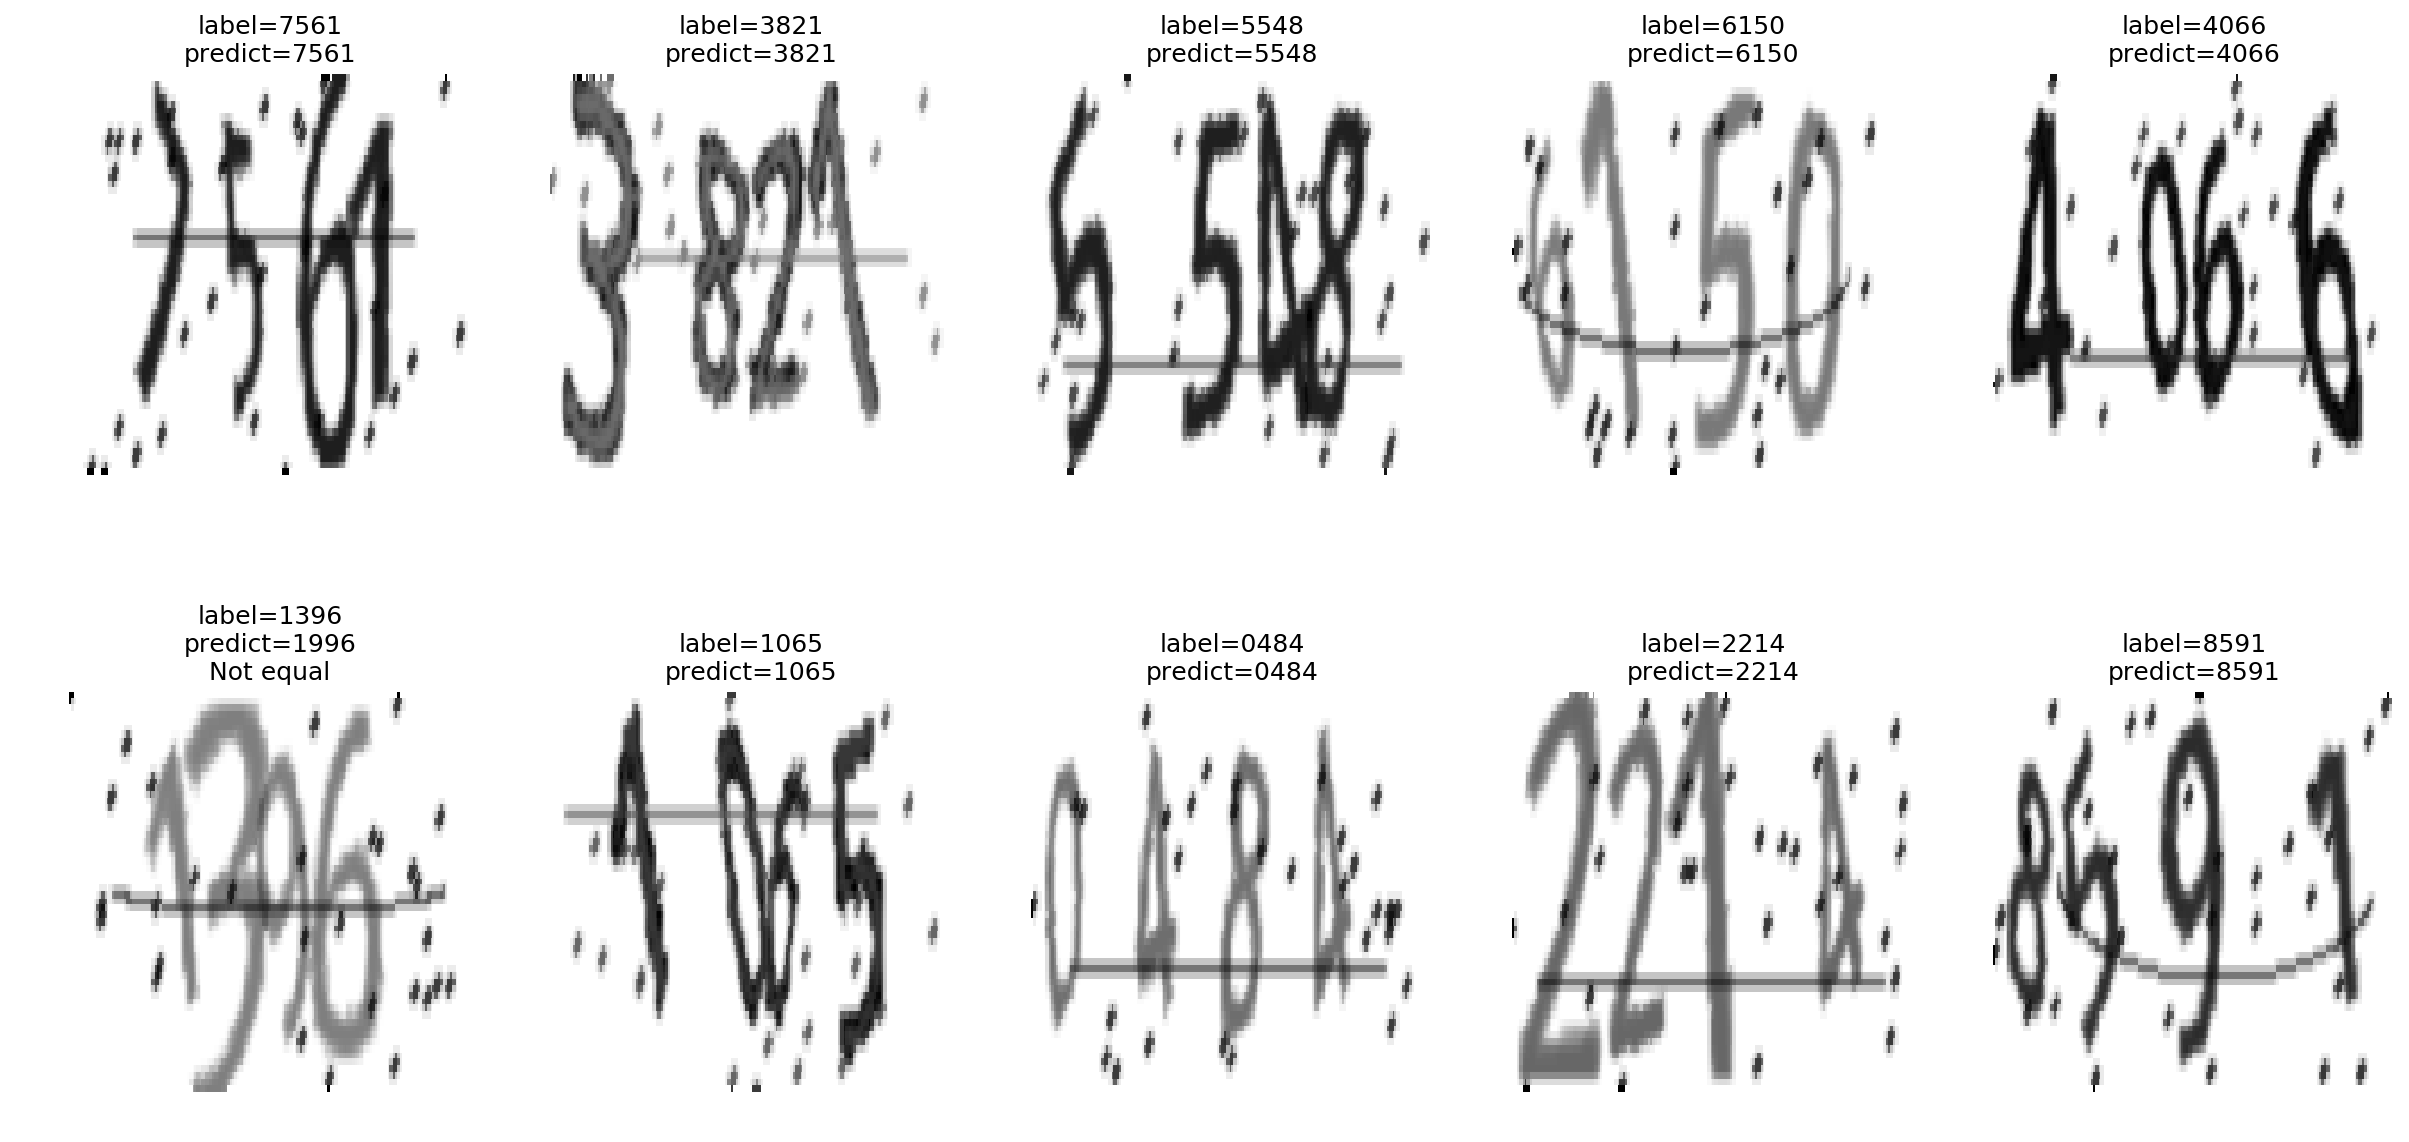

In [6]:
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'captcha/model/crack_captcha.model-3253')
    
    batch_image, label0, label1, label2, label3 = sess.run(next_element)
    pred0, pred1, pred2, pred3 = sess.run([y_pred0, y_pred1, y_pred2, y_pred3], feed_dict={x: batch_image})
        
    # int to string
    label0 = [str(x) for x in label0]
    label1 = [str(x) for x in label1]
    label2 = [str(x) for x in label2]
    label3 = [str(x) for x in label3]
    pred0 = [str(x) for x in pred0]
    pred1 = [str(x) for x in pred1]
    pred2 = [str(x) for x in pred2]
    pred3 = [str(x) for x in pred3]
    
    fig = plt.figure(figsize=(20, 10), dpi=150)
    for i in range(10):
        # 顯示圖片
        
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(batch_image[i], cmap='gray')
        ax.axis('off')
        
        title_label = label0[i] + label1[i] + label2[i] + label3[i]
        title_predict = pred0[i] + pred1[i] + pred2[i] + pred3[i]
        title = 'label=' + title_label + '\n' + 'predict=' + title_predict
        
        if title_label != title_predict:
            title += '\n' + 'Not equal'
        ax.set_title(title)